# Network Visualization (PyTorch)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

This notebook uses **PyTorch**; we have provided another notebook which explores the same concepts in TensorFlow. You only need to complete one of these two notebooks.

In [3]:
'''
import torch
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import random

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
'''
from __future__ import print_function, division

import pickle
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
from PIL import Image
import time
import copy
import shutil
%matplotlib inline
from torchvision import  transforms

# Pretrained Model

For now using our pretrained ResNet, will also do for LSTM 

In [4]:
class Resnet34_only(nn.Module):
   
    NUM_VID_FEATURES = 128
    NUM_PARTITIONS = 10
    NUM_CLASS = 5
    NUM_IMG_SIZE = 256
    NUM_CHANNEL = 3
    
    def __init__(self):        
        super(Resnet34_only, self).__init__()
        self.videoBranch = self._createVideoBranch()
        self.droupout = nn.Dropout(p=0.35)
        self.fc = nn.Linear(self.NUM_VID_FEATURES,self.NUM_CLASS)
        self.sigmoid = nn.Sigmoid()
        
    def _createVideoBranch(self):
        model_pretrained = torchvision.models.resnet34(pretrained=True)
        # All of the parameters are freezed, not to change (newly constructed layers' params won't be influenced)
        for param in model_pretrained.parameters():
            param.requires_grad = False   
        model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, self.NUM_VID_FEATURES)
        return model_pretrained
    
    def forward(self, x):
        x = self.videoBranch(x)
        x = self.droupout(x)
        x = self.fc(x)
        x = self.sigmoid(x) #(N,5)
        return x   

use_gpu = True
# dtype = torch.cuda.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

modelCheckpointPath = '../resNetExperiments/resnet_for_rnn/ResNet34_ONLY_experiment_L2_dropout/checkpoint.pth.tar'
model = Resnet34_only().type(gpu_dtype)
criterion = nn.MSELoss().type(gpu_dtype)
print("=> loading checkpoint '{}'".format(modelCheckpointPath))
checkpoint = torch.load(modelCheckpointPath)
model.load_state_dict(checkpoint['state_dict'])
# model = model.float()
print("=> loaded checkpoint '{}' (epoch {})".format(modelCheckpointPath, checkpoint['epoch']))

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters(): # This is probably fine to do as well
    param.requires_grad = False 

=> loading checkpoint '../resNetExperiments/resnet_for_rnn/ResNet34_ONLY_experiment_L2_dropout/checkpoint.pth.tar'
=> loaded checkpoint '../resNetExperiments/resnet_for_rnn/ResNet34_ONLY_experiment_L2_dropout/checkpoint.pth.tar' (epoch 52)


# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [5]:
import genericDataBaseAccess
import importlib

processing dataset: /home/noa_glaser/dataBig/train-frames/train
processing dataset: /home/noa_glaser/dataBig/train-frames/val


In [6]:
genericDataBaseAccess = importlib.reload(genericDataBaseAccess)
from  genericDataBaseAccess import returnSampleDataBatch


# train_imgsamples,train_labelsample  =
# train_unflattened_sample = train_imgsamples.view(-1,3,256,256)
# # a = torch.ones()
# train_unflattened_sample.size()


def compute_saliency_maps(input_image, emotionIndx): # emotion indx is out of 5 for the 5 outputs of the model 
    # Make sure the model is in "test" mode
    model.eval()
    
    oneImageVar =   Variable(input_image.type(gpu_dtype),requires_grad=True)
    # compute output
    output = model(oneImageVar)
    outputOne = output[0,emotionIndx] # zerop is first image, i is ith class 
    outputOne.backward(retain_variables=True )

    # converting to 1 color like Piazza post 1903
    return oneImageVar.grad.data.abs().max(dim=1)[0].squeeze()
        

processing dataset: /home/noa_glaser/dataBig/train-frames/train
processing dataset: /home/noa_glaser/dataBig/train-frames/val


In [ ]:
input_image, target =  returnSampleDataBatch()
oneImage = input_image.view(-1,3,256,256)[0:1,:,:,:]

one
def gradientCheckQuick(input_image, emotionIndx): # emotion indx is out of 5 for the 5 outputs of the model 
    # Make sure the model is in "test" mode
    model.eval()
    
    oneImageVar =   Variable(input_image.type(gpu_dtype),requires_grad=True)
    # compute output
    output = model(oneImageVar)
    outputOne = output[0,emotionIndx] # zerop is first image, i is ith class 
    outputOne.backward(retain_variables=True )

    # converting to 1 color like Piazza post 1903
    return oneImageVar.grad.data.abs().max(dim=1)[0].squeeze()

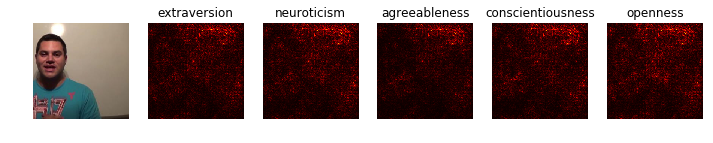

In [11]:
def show_saliency_maps():
    # Convert X and y from numpy arrays to Torch Tensors
#     X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X],0)
#     y_tensor = torch.LongTensor(y)
    # Compute saliency maps for images in X
    personalities = ['extraversion','neuroticism','agreeableness','conscientiousness','openness']
    numPersonalities = len(personalities)

    input_image, target =  returnSampleDataBatch()
    oneImage = input_image.view(-1,3,256,256)[0:1,:,:,:]

    inp = oneImage[0].cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean    
    plt.subplot(1, numPersonalities +1,1)
    plt.axis('off')
    plt.imshow(inp)
                
    for p in range(numPersonalities):
        saliency = compute_saliency_maps(oneImage, p)

        saliency = saliency.cpu().numpy()
        plt.subplot(1,numPersonalities + 1, p+2 )
        plt.imshow(saliency, cmap=plt.cm.hot)
        plt.title(personalities[p])
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)

#     N = X.shape[0]
#     for i in range(N):
#         plt.subplot(2, N, i + 1)
#         plt.imshow(X[i])
#         plt.axis('off')
#         plt.title(class_names[y[i]])
#         plt.subplot(2, N, N + i + 1)
#         plt.imshow(saliency[i], cmap=plt.cm.hot)

#         plt.axis('off')
#         plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps()

# Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I s_y(I) - R(I)
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [ ]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], 3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], 2)
    return X

In [ ]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and also wrap it in
    # a PyTorch Variable.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype)
    img_var = Variable(img, requires_grad=True)

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.copy_(jitter(img, ox, oy))
        img_var = Variable(img, requires_grad=True)
        output = model(img_var).squeeze()
        output[target_y].backward(retain_variables=True)
        grad = img_var.grad
        grad = torch.mul(grad, learning_rate)
#         grad = torch.div(torch.mul(grad, learning_rate),grad.norm().data[0])

        img_norm = img.norm()
        img = torch.add(img, grad.data)
        reg = torch.mul(grad.data, -2*l2_reg)
        img = torch.add(img,reg)
        
        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        
        # Undo the random jitter
        img.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.cpu())

Once you have completed the implementation in the cell above, run the following cell to generate an image of a Tarantula:

In [ ]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)